In [1]:
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

### Задача со звездочкой 11: NNLS.
Напишите свою Non-Negative-Least-Squares на numpy **(scipy.optimize нельзя)**.

Подробно прокомментируйте, почему ваш алгоритм работает.

**1. Алгоритм NNLS:**

$$
arg \ min_{b}||Xb-y||_{2}^{2}, \ b \ge 0
$$

**Аргументы:**

X - (m, n) матрица признаков.

y - (m,) вектор значений.

tol - допустимая ошибка для выхода из алгоритма.

max_iter - максимальное число итераций.

**Функция возвращает:**

b - (n,) вектор коэффициентов.

**2. Условие оптимального решения:**

$$
w=X^{T}(y-Xb) \ge 0
$$

**3. Что за активные и пассивные компоненты весов b:**

- Активные переменные участвуют в оптимизации
- Пассивные переменные зафиксированы на 0
- Алгоритм перемещает веса между активным A и пассивным P наборами, для разделения сложной задачи оптимизации на подзадачи. Если градиент пассивных весов становится положительным - это сигнал, что компонента должна быть добавлена в активный набор, так как она может улучшить решение регрессии. Если при вычислении одна из компонент становится отрицательной, она возвращается в пассивный набор. Таким образом, мы как бы отсеиваем веса, которые отрицательные.

**4. Оптимизация по активным переменным:**

Для активного подмножества переменных решается задача наименьших квадратов

$$
X_{a}b_{a}=y,
$$
где $X_{a}$ подматрица $X$, соответсвующая активным переменным.

**5.Что за альфа?**

Альфа корректирует вектор весов b, если в нем есть отрицательные значения.

Находим афльфа для отрицательного значения:
$$
\alpha=min(\frac{b_{i}}{b_{i}-b_{i}^{new}}),
$$

где $b_{i}$ - элемент предыдущего решения, $b_{i}^{new}$ - отрицательный элемент текущего решения

Обновляем $b_{A}$ по формуле:
$$
b_A=b_A+\alpha(b_A^{new}-b_A)
$$

In [2]:
def nnls(X, y, tol=1e-8, max_iter=500):
    
    m, n = X.shape
    b = np.zeros(n)             # Решение (начальное приближение)
    w = X.T @ (y - X @ b)       # Вектор градиентов
    A = np.zeros(n, dtype=bool) # Индикатор активных переменных
    P = ~A                      # Индикатор пассивных переменных (нулевых)
    
    iter_count = 0

    while iter_count < max_iter:
        iter_count += 1
        
        # Шаг 1: Проверяем условие оптимальности
        if np.all(w[P] <= tol): # Если все градиенты пассивных переменных <= 0, решение оптимально
            break
        
        # Шаг 2: Находим индекс переменной, которая "наиболее нарушает" ограничение
        t = np.argmax(w * P) # Переменная с максимальным градиентом (в P)
        A[t] = True          # Переносим переменную в активный набор
        P[t] = False         # Убираем переменную из пассивного набора
        
        # Шаг 3: Находим оптимальное решение для активного набора
        while True:
            # Минимизируем ||X_A b_A - y||²
            X_A = X[:, A]
            b_A = np.linalg.pinv(X_A) @ y  # Решение в активном пространстве
            
            if np.all(b_A >= 0): # Если все компоненты ba >= 0, решение допустимо
                b[A] = b_A
                break
            
            # Шаг 4: Ищем "переключающую" точку (переменную, пересекающую 0)
            alpha = np.min(b[A][b_A < 0] / (b[A][b_A < 0] - b_A[b_A < 0]))
            b[A] += alpha * (b_A - b[A]) # Интерполируем к границе
            A[b < tol] = False          # Убираем переменные из активного набора
            P = ~A                      # Обновляем индикаторы
            
        # Шаг 5: Обновляем градиенты
        w = X.T @ (y - X @ b)
    
    return b

LinearRegression Coefficients: -647.3466141356599 153.0336939672656
NNLS Coefficients: 0.0 153.36255924170615
Mean squared error (LinearRegression): 4538.340456055545
Mean squared error (NNLS): 5568.964624559196


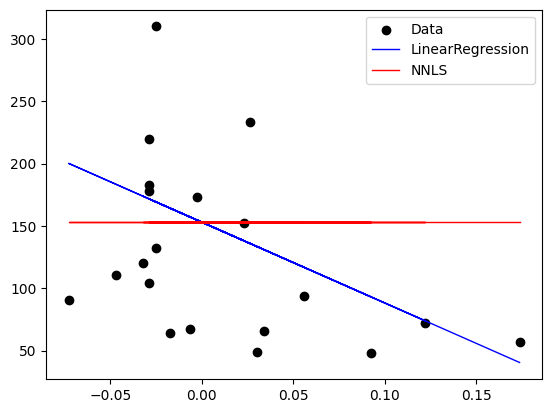

In [3]:
# Пример использования
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 6]

diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

regr = LinearRegression()
regr.fit(diabetes_X_train, diabetes_y_train)

# Обучение с nnls
X_train_with_intercept = np.hstack([np.ones((diabetes_X_train.shape[0], 1)), diabetes_X_train])
coefficients_nnls = nnls(X_train_with_intercept, diabetes_y_train)
intercept_nnls, coef_nnls = coefficients_nnls[0], coefficients_nnls[1]

# Предсказания
diabetes_y_pred = regr.predict(diabetes_X_test)
X_test_with_intercept = np.hstack([np.ones((diabetes_X_test.shape[0], 1)), diabetes_X_test])
diabetes_y_pred_nnls = X_test_with_intercept @ coefficients_nnls

print("LinearRegression Coefficients:", regr.coef_[0], regr.intercept_)
print("NNLS Coefficients:", coef_nnls, intercept_nnls)

print("Mean squared error (LinearRegression):", mean_squared_error(diabetes_y_test, diabetes_y_pred))
print("Mean squared error (NNLS):", mean_squared_error(diabetes_y_test, diabetes_y_pred_nnls))

plt.scatter(diabetes_X_test, diabetes_y_test, color="black", label="Data")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=1, label="LinearRegression")
plt.plot(diabetes_X_test, diabetes_y_pred_nnls, color="red", linewidth=1, label="NNLS")
plt.legend()
plt.show()

### Задача со звездочкой 12: ODR.
Откройте [ODRPACK User Guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf) (осторожно: FORTRAN-77), и разберитесь что происходит в этом примере, поищите более современные данные и воспроизведитеng)